In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler

# Deep learning import
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Evaluation Imports
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Configurations
isDemoMode = True

# Define Helper functions
- split_sequence: This function is used to split a univariate time series into sequences consist of n steps.
 Steps are given by user. For example in our case it would be 60 steps (for 60 minutes lag.)

In [3]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def train_test_valid_split(total_x, total_y, train_size=0.9, valid_size=0.1) :
    train_index = int(len(total_x) * train_size)
    valid_index = int(len(total_x) * valid_size)

    X_train, y_train = total_x[0 :train_index], total_y[0 :train_index]
    X_valid, y_valid = total_x[train_index :train_index + valid_index], total_y[train_index :train_index + valid_index]
    X_test, y_test = total_x[train_index + valid_index :], total_y[train_index + valid_index :]

    print("-------- train test valid split --------")
    print(len(X_train)), print(len(y_train))
    print(len(X_valid)), print(len(y_valid))
    print(len(X_test)), print(len(y_test))
    print("----------------------------------------")

    return np.array(X_train), \
           np.array(y_train), \
           np.array(X_valid), \
           np.array(y_valid), \
           np.array(X_test), \
           np.array(y_test)

def display_training_curves(training, validation, title, subplot=None) :
    if subplot is not None:
        ax = plt.subplot(subplot)
    else:
        ax = plt.subplot()
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])
    plt.show()
    return


 ### Update Default number of DF columns

In [4]:
print(f"Default number of DF columns displayed {pd.get_option('display.max_columns')}")

# settings to display all columns
pd.set_option("display.max_columns", None)

Default number of DF columns displayed 20


# Load Test data from CSV

In [5]:
df = pd.read_csv ('../flatten_crypto_data.csv')
df

,high_24h,last_24h,unix_timestamp,bid_24h,vwap_24h,volume_24h,low_24h,ask_24h,open_24h,high_1min,volume_1min,low_1min,close_1min,open_1min,max_supply,circulating_supply,total_supply,quote_USD_price,quote_volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap
0,62971.54,62561.13,1635527368,62559.74,60908.08,5113.537402,56425.0,62561.13,60608.95,62565.90,1.425169,62539.20,62561.86,62545.45,21000000.0,18858012.0,18858012.0,62556.005047,4.304916e+10,6.0514,-0.314446,2.307206,2.108769,50.683466,29.933036,51.410352,1.179682e+12,44.2449,1.313676e+12
1,62971.54,62580.05,1635527309,62571.40,60907.24,5111.938615,56425.0,62580.05,60608.95,62580.05,0.046548,62555.88,62577.47,62555.88,21000000.0,18858012.0,18858012.0,62530.948307,4.305221e+10,6.0179,-0.422853,2.137546,2.146984,50.578304,29.917416,51.320919,1.179209e+12,44.2040,1.313150e+12
2,62971.54,62591.17,1635527428,62582.19,60908.89,5115.569587,56425.0,62596.03,60608.95,62597.65,2.112533,62555.02,62597.64,62560.95,21000000.0,18858012.0,18858012.0,62551.924819,4.304739e+10,6.0643,-0.365020,2.383982,2.150485,50.771799,29.997052,51.453950,1.179605e+12,44.2421,1.313590e+12
3,62971.54,62590.43,1635527672,62572.06,60909.91,5117.061581,56425.0,62590.43,60608.95,62615.00,0.596406,62590.43,62590.43,62603.62,21000000.0,18858012.0,18858012.0,62591.537709,4.311295e+10,6.1673,-0.311393,2.375399,2.464668,50.828620,30.044297,51.488766,1.180352e+12,44.2517,1.314422e+12
4,62971.54,62600.43,1635527551,62587.09,60909.54,5117.193435,56425.0,62606.26,60608.95,62600.43,0.657752,62577.18,62600.43,62577.18,21000000.0,18858012.0,18858012.0,62584.316178,4.310036e+10,6.1706,-0.379612,2.422122,2.443523,50.807128,30.074340,51.475109,1.180216e+12,44.2650,1.314271e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246786,38786.95,38327.07,1651352348,38304.93,38539.95,534.789447,38160.4,38326.82,38599.30,38327.07,0.000650,38327.07,38327.07,38327.07,21000000.0,19026825.0,19026825.0,38334.504957,2.115848e+10,-24.4114,-0.363037,-0.606400,-3.693057,-16.314320,-12.909292,1.689268,7.293839e+11,42.0516,8.050246e+11
246787,38786.95,38332.23,1651352290,38314.66,38539.96,535.007039,38160.4,38335.17,38599.30,38332.23,0.000000,38332.23,38332.23,38332.23,21000000.0,19026825.0,19026825.0,38332.043361,2.114067e+10,-24.4769,-0.344114,-0.592877,-3.713096,-16.308426,-12.839252,1.692403,7.293371e+11,42.0489,8.049729e+11
246788,38786.95,38329.94,1651352410,38317.93,38539.93,534.564625,38160.4,38330.19,38599.30,38317.93,0.007191,38317.93,38317.93,38317.93,21000000.0,19026825.0,19026825.0,38337.264339,2.115928e+10,-24.4040,-0.345789,-0.598362,-3.683293,-16.296175,-12.917047,1.698228,7.294364e+11,42.0546,8.050826e+11
246789,38786.95,38344.79,1651352469,38321.67,38539.90,534.297570,38160.4,38344.79,38599.30,38344.79,0.000000,38344.79,38344.79,38344.79,21000000.0,19026825.0,19026825.0,38334.446382,2.115736e+10,-24.4076,-0.354289,-0.602308,-3.686438,-16.303936,-12.928782,1.698071,7.293828e+11,42.0515,8.050234e+11


# Print the number of Dataset observations.


In [6]:
len(df)

246791

# Plot Last minute Close price

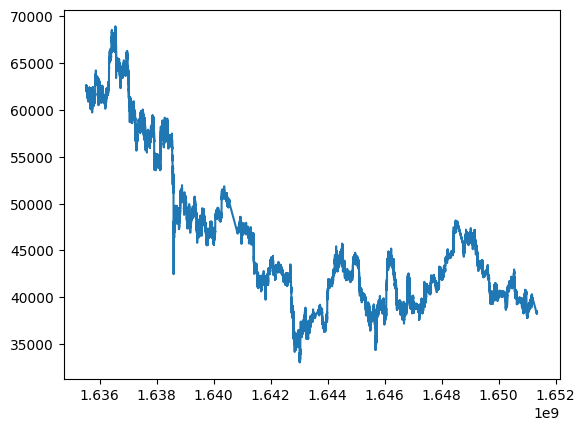

In [7]:
plt.plot(df['unix_timestamp'], df['close_1min'] )
plt.show()

## Data Preprocessing
- Scale Data
- Get total_x and total_y based on prediction days
- convert them in np arrays
- reshape total_x

In [8]:
test_df = df.tail(round(0.10 * len(df))) if isDemoMode else df

# scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(test_df["close_1min"].values.reshape(-1,1))
scaled_data

array([[0.37339388],
       [0.3830335 ],
       [0.39306948],
       ...,
       [0.10548362],
       [0.11065168],
       [0.10964154]])

# Bitcont Price Predicition Preperations

Gia na pragmatopoisoume provlepsi tis timis tou bitcoin tha xtrisimopoiisoume tin timi **`close_1min`** prokoimenou na
provlepsoume me tin timi me tin opoia tha klisi to BTC sto epomeno lepto.

Gia na ekpedeusoume kai na dokimasoume ta montela mas tha xorisoume to dataset mas se 2 yposinola
- train_set: to opoio tha periexei to 90% ton paratirisewn
- test_set: to opoio tha periexei to 10% ton paratirisewn.

In [9]:
n_steps = 60
X, y = split_sequence(scaled_data, n_steps)

print(f"Split Dataset X length: {len(X)}")
print(f"Split Dataset y length: {len(y)}")

Split Dataset X length: 24619
Split Dataset y length: 24619


# Create Vanilla LSTM

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

- Dilonoume Sto LSTM to shape pou tha exoun ta inputs tou.
- Epidi provlepoume univariate series exoume panta 1 xaraktiristiko gia kathe paratirisi. (px lepto sto BTC) ara ***`n_features = 1`***
- opote to LSTM input shape prepei na einai (n_steps, n_features) opou n_steps to noumero ton lags pou orisame sto Data preprocessing.
- Opote prepei na metasximatisoume ta dedomena mas apo ena 2D array se ena 3D array opou
    - 1st D => to plithos ton paratiriseon (gia tis opoies ipaexoun n_step proigoumenes paratirisis)
    - 2nd D => oso einai to plithos twn lags pou epileksame (n_step)
    - 3ed D => to plithos ton xaraktiristikon (univariate = 1)

In [10]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[0.37339388],
        [0.3830335 ],
        [0.39306948],
        ...,
        [0.37964135],
        [0.37448483],
        [0.37964712]],

       [[0.3830335 ],
        [0.39306948],
        [0.37943163],
        ...,
        [0.37448483],
        [0.37964712],
        [0.37474265]],

       [[0.39306948],
        [0.37943163],
        [0.39726012],
        ...,
        [0.37964712],
        [0.37474265],
        [0.38660073]],

       ...,

       [[0.13210706],
        [0.1311758 ],
        [0.13202432],
        ...,
        [0.10674773],
        [0.10724222],
        [0.10823505]],

       [[0.1311758 ],
        [0.13202432],
        [0.13257845],
        ...,
        [0.10724222],
        [0.10823505],
        [0.10548362]],

       [[0.13202432],
        [0.13257845],
        [0.13862198],
        ...,
        [0.10823505],
        [0.10548362],
        [0.11065168]]])

Train test split

In [11]:
train_X, train_y, valid_X, valid_y, _, _ = train_test_valid_split(
        X,
        y,
        train_size=0.8,
        valid_size=0.1
    )
print("----------------------------")
print(f"-------- Train X: {train_X.shape}, Train y: {train_y.shape} --------")
print(f"-------- Valid X: {valid_X.shape}, Valid y: {valid_y.shape} --------")
# print(f"-------- Test X: {test_X.shape}, Test y: {test_y.shape} --------")
print("----------------------------\n")

-------- train test valid split --------
19695
19695
2461
2461
2463
2463
----------------------------------------
----------------------------
-------- Train X: (19695, 60, 1), Train y: (19695, 1) --------
-------- Valid X: (2461, 60, 1), Valid y: (2461, 1) --------
----------------------------



In [12]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2022-09-11 19:14:51.029470: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# fit model
history = model.fit(
    X,
    y,
    epochs=200,
    verbose=2,
    validation_data=(valid_X, valid_y),
    shuffle=False,
)

Epoch 1/200
770/770 - 10s - loss: 0.0031 - val_loss: 0.0131
Epoch 2/200
770/770 - 8s - loss: 0.0012 - val_loss: 0.0073
Epoch 3/200
770/770 - 8s - loss: 0.0012 - val_loss: 0.0056
Epoch 4/200
770/770 - 8s - loss: 9.2105e-04 - val_loss: 0.0039
Epoch 5/200
770/770 - 8s - loss: 6.1620e-04 - val_loss: 0.0025
Epoch 6/200
770/770 - 8s - loss: 4.0509e-04 - val_loss: 0.0019
Epoch 7/200
770/770 - 8s - loss: 3.0258e-04 - val_loss: 0.0017
Epoch 8/200
770/770 - 8s - loss: 2.7699e-04 - val_loss: 0.0019
Epoch 9/200
770/770 - 8s - loss: 2.8691e-04 - val_loss: 0.0021
Epoch 10/200
770/770 - 8s - loss: 3.0183e-04 - val_loss: 0.0032
Epoch 11/200
770/770 - 8s - loss: 3.5399e-04 - val_loss: 0.0020
Epoch 12/200
770/770 - 8s - loss: 3.3344e-04 - val_loss: 0.0017
Epoch 13/200
770/770 - 8s - loss: 3.1079e-04 - val_loss: 0.0015
Epoch 14/200
770/770 - 8s - loss: 3.0905e-04 - val_loss: 0.0014
Epoch 15/200
770/770 - 8s - loss: 3.1900e-04 - val_loss: 0.0013
Epoch 16/200
770/770 - 8s - loss: 3.2534e-04 - val_loss: 0.0

2022-09-11 19:14:51.139755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


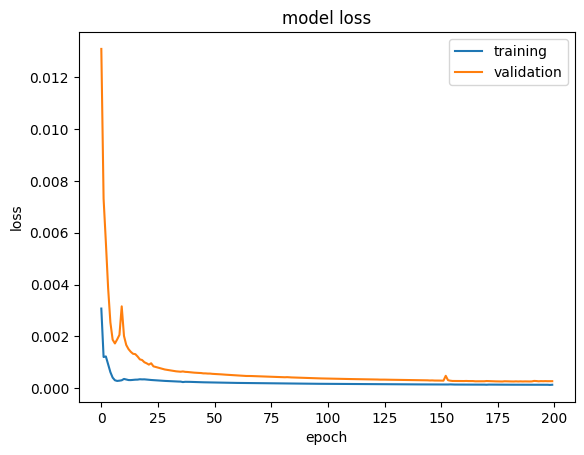

In [14]:
# display training curves
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss')

In [15]:
# make a prediction
y_predict = model.predict(valid_X)

In [16]:
# invert scaling for forecast
inv_y_predict = scaler.inverse_transform(y_predict)
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(valid_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 84.995
